In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

Читаем данные - информацию о моделировании работы ЦОД за 30 дней. Наблюдения велись каждые 12 минут.

Получаем два датафрейма для модели ЦОД, где стоят уставки системы охлаждения в 18 и 22 градусов (назовем эти константные модели C18 и C22 соответственно).

И датафрейм для модели ЦОД, в которой контроль среды осущвствлялся моделью RL-агентом (PPO).

In [146]:
sim_df_18 = pd.read_parquet('../data/simulation_data_SP18.parquet')
sim_df_22 = pd.read_parquet('../data/simulation_data_SP22.parquet')
rl_df = pd.read_parquet('../data/PPO_baseline_data.parquet')

# Данные состоят из следующих колонок
rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cooling_setpoint                        3600 non-null   float64
 1   Humidity_setpoint                       3600 non-null   float64
 2   AHU_Supply_Temp                         3600 non-null   float64
 3   Facility_Total_Electricity_Demand_Rate  3600 non-null   float64
 4   Temp_Z_1                                3600 non-null   float64
 5   Temp_Z_2                                3600 non-null   float64
 6   Temp_Z_3                                3600 non-null   float64
 7   Temp_Z_4                                3600 non-null   float64
 8   Temp_Z_5                                3600 non-null   float64
 9   Temp_Z_6                                3600 non-null   float64
 10  Temp_Z_7                                3600 non-null   floa

Статистики по температурам в корридорах, контролируемых моделью

In [147]:
zones_temp_cols = [x for x in rl_df.columns if 'Temp_Z' in x]

RH_control_zones = [x for x in rl_df.columns if 'RH_' in x]

cold_aisles = [zones_temp_cols[i] for i in range(len(zones_temp_cols)) if i & 1]
hot_aisles = [zones_temp_cols[i] for i in range(len(zones_temp_cols)) if i % 2 == 0]

rl_df[zones_temp_cols].describe()

,Temp_Z_1,Temp_Z_2,Temp_Z_3,Temp_Z_4,Temp_Z_5,Temp_Z_6,Temp_Z_7,Temp_Z_8,Temp_Z_9,Temp_Z_10,Temp_Z_11
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,35.205504,24.269421,38.137087,24.269345,38.137033,24.269345,38.137122,24.269488,34.745701,24.269570,35.207434
std,0.190762,0.162231,0.172556,0.159387,0.171784,0.159386,0.172678,0.162710,0.168724,0.165954,0.194129
min,28.926156,18.000346,31.711416,18.000332,31.711410,18.000332,31.711416,18.000348,28.377191,18.000362,28.925031
25%,35.099327,24.189946,38.050742,24.193054,38.051274,24.193056,38.050613,24.189784,34.663055,24.187249,35.098786
50%,35.202214,24.270888,38.139070,24.270566,38.138394,24.270569,38.138918,24.270862,34.747624,24.270329,35.204716
75%,35.314090,24.352106,38.225312,24.349423,38.224927,24.349423,38.225324,24.352640,34.828975,24.355312,35.319040
max,35.777767,24.962305,38.726947,24.986570,38.725317,24.986574,38.727222,24.960001,35.311337,24.900258,35.831975


Есть ли коридоры в которых температура поднялась выше порога (25) для холондого и 45 для горячего?

In [148]:
print('Превышение температуры в холодных коридорах:', (rl_df[cold_aisles] > 25).sum().sum())

print('Превышение температуры в горячих коридорах:', (rl_df[hot_aisles] > 45).sum().sum())

Превышение температуры в холодных коридорах: 0
Превышение температуры в горячих коридорах: 0


Статистики по температурам в корридорах, контролируемых константными уставками:

In [149]:
# Для уставки системы охлаждения = 18 градусов (модель C18)
sim_df_18[zones_temp_cols].describe()

,Temp_Z_1,Temp_Z_2,Temp_Z_3,Temp_Z_4,Temp_Z_5,Temp_Z_6,Temp_Z_7,Temp_Z_8,Temp_Z_9,Temp_Z_10,Temp_Z_11
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,29.037377,18.093681,31.756998,18.100510,31.760511,18.100774,31.759625,18.098725,28.437085,18.090573,29.036499
std,0.313100,0.288403,0.314832,0.303747,0.322573,0.304382,0.320749,0.299985,0.302682,0.281483,0.305223
min,28.692055,17.999222,31.503362,17.999188,31.503362,17.999188,31.503361,17.999275,28.211690,17.999313,28.690692
25%,28.876374,18.000506,31.612520,18.000506,31.612594,18.000506,31.612524,18.000506,28.306277,18.000505,28.874907
50%,28.956966,18.000523,31.666002,18.000525,31.666528,18.000525,31.666145,18.000523,28.352360,18.000522,28.957791
75%,29.068944,18.000545,31.732876,18.000550,31.733441,18.000550,31.733135,18.000544,28.400999,18.000539,29.079345
max,30.819370,19.855962,33.664196,19.917836,33.696390,19.920444,33.689509,19.904287,30.291540,19.831351,30.798372


In [150]:
# Для уставки системы охлаждения = 22 градусов (модель C22)
sim_df_22[zones_temp_cols].describe()

,Temp_Z_1,Temp_Z_2,Temp_Z_3,Temp_Z_4,Temp_Z_5,Temp_Z_6,Temp_Z_7,Temp_Z_8,Temp_Z_9,Temp_Z_10,Temp_Z_11
count,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
mean,32.881568,21.999890,35.774022,21.999872,35.774012,21.999872,35.774023,21.999893,32.405312,21.999911,32.883387
std,0.108521,0.003705,0.070034,0.004498,0.070150,0.004498,0.070012,0.003558,0.056529,0.002741,0.111502
min,31.365330,21.780705,34.576536,21.733367,34.553176,21.733354,34.580877,21.789483,31.344706,21.838629,31.414637
25%,32.799818,21.999855,35.723396,21.999847,35.723394,21.999846,35.723396,21.999855,32.364868,21.999862,32.798948
50%,32.872353,22.000002,35.771937,22.000002,35.771935,22.000002,35.771936,22.000002,32.404734,22.000002,32.872689
75%,32.961603,22.000091,35.826226,22.000094,35.826219,22.000094,35.826225,22.000090,32.444492,22.000088,32.965377
max,33.128990,22.001581,35.948874,22.001677,35.948874,22.001677,35.948874,22.001564,32.550451,22.001458,33.145062


Зачения уставок:

In [151]:
# Средние показатели уставок агента

str_setpoints = "Mean HVAC cooling setpoint: {}\nMean AHU supply temperature: {}\nMean humidity setpoint: {}"
print(str_setpoints.format(
        np.mean(rl_df['cooling_setpoint']),
        np.mean(rl_df['AHU_Supply_Temp']),
        np.mean(rl_df['Humidity_setpoint']))
     )

Mean HVAC cooling setpoint: 24.267679193942627
Mean AHU supply temperature: 14.086208748122056
Mean humidity setpoint: 29.058611696054538


Посчитаем сколько энергии на охлаждение потралила модель за весь период моделирования

In [152]:
# Энергия затраченная RL-агентом на охлаждерние
model_energy = sum(rl_df['Air_System_Total_Cooling_Energy'])
model_energy

1193925211.8206618

In [153]:
# Энергия затраченная константными моделями C18, C122
C18_energy = sum(sim_df_18['Air_System_Total_Cooling_Energy'])
C22_energy = sum(sim_df_22['Air_System_Total_Cooling_Energy'])

print(f'Air System Total Cooling Energy:\nC18 = {C18_energy};\nC16 = {C22_energy}.')

Air System Total Cooling Energy:
C18 = 1313791704.063882;
C16 = 1267777597.8775163.


In [154]:
# Посмотрим сколько сэкономили
delta_C22 = C22_energy - model_energy
delta_C18 = C18_energy - model_energy
print(f'Разница с моделью C22: {delta_C22}\nРазница с моделью C18: {delta_C18}')

Разница с моделью C22: 73852386.05685449
Разница с моделью C18: 119866492.24322033


In [155]:
# Посмотрим сколько это в долях от энергии затраченной константными моделями
print('For C22:', delta_C22 / C22_energy)
print('For C18:', delta_C18 / C18_energy)

For C22: 0.0582534240867613
For C18: 0.09123705978081889


Гистограммы распределения значений уставок для контролируемых агентом параметров:

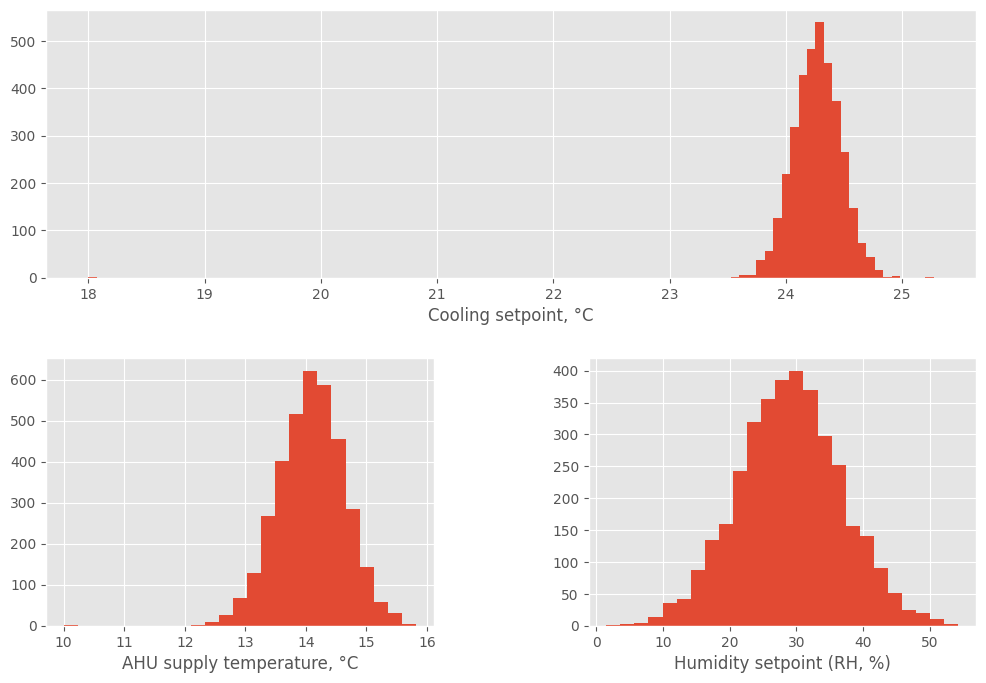

In [156]:
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
main_ax = fig.add_subplot(grid[0, 0:])
main_ax.set_xlabel('Cooling setpoint, °C')

b_ax1 = fig.add_subplot(grid[1, 0])
b_ax1.set_xlabel('AHU supply temperature, °C')

b_ax2 = fig.add_subplot(grid[1, 1])
b_ax2.set_xlabel('Humidity setpoint (RH, %)')


main_ax.hist(rl_df['cooling_setpoint'], bins=100)
b_ax1.hist(rl_df['AHU_Supply_Temp'], bins=25)
b_ax2.hist(rl_df['Humidity_setpoint'], bins=25);

Как и хотелось, они распределены нормально (есть небольшие выбросы, но это из-за первой строки уставок):

In [157]:
rl_df[['cooling_setpoint', 'Humidity_setpoint', 'AHU_Supply_Temp']].head(3)

,cooling_setpoint,Humidity_setpoint,AHU_Supply_Temp
0,18.000500,30.400000,10.000000
1,25.273952,40.397572,12.945840
2,23.597859,18.254802,15.739213


Cравним также нашего агента с константным агентом, который имеет уставку в 25 градусов для охлаждения (модель С25)

In [161]:
sim_df_25 = pd.read_parquet('../data/simulation_data_SP25.parquet')

C25_energy = sum(sim_df_25['Air_System_Total_Cooling_Energy'])

print(f'Air System Total Cooling Energy:\nC25 = {C25_energy}.\n')

# Сколько сэкономили:

delta_C25 = C25_energy - model_energy
print(f'Разница модели C25 и агента: {delta_C25};\n')

print('В долях:', delta_C25 / C25_energy)

Air System Total Cooling Energy:
C25 = 1245698395.9300811.

Разница модели C25 и агента: 51773184.109419346;

В долях: 0.041561572430832035
